# MNEflow basic calssification example

# 1. Importing data

### 1.1.from MNE epochs

If you use MNE-python, all you need is to provide your epochs file (or list of epoch files) to mneflow.produce_tfrecords


In [1]:
#%pylab inline
#get epochs using your mne-python pipeline
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=PendingDeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)

import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

import sys
import os
from time import time, strftime, gmtime
import gc

import numpy as np
import mne
from mne.datasets import multimodal

os.chdir('/u/20/vranoug1/unix/OPM-BCI/mneflow-dev/mneflow/')
import mneflow
from mneflow import keras_models

from mneflow.keras_utils import plot_metrics, plot_output, plot_history_v2
from mneflow.keras_utils import mse_weighted, mae_weighted
from mneflow.keras_utils import r_square, soft_acc, rmse

# Force enable eager execution after importing mneflow
tf.compat.v1.enable_eager_execution()
mne.set_log_level(verbose='CRITICAL')

fname_raw = os.path.join(multimodal.data_path(), 'multimodal_raw.fif')
raw = mne.io.read_raw_fif(fname_raw)

cond = raw.acqparser.get_condition(raw, None)
# get the list of condition names
condition_names = [k for c in cond for k,v in c['event_id'].items()]

epochs_list = [mne.Epochs(raw, **c) for c in cond]

epochs = mne.concatenate_epochs(epochs_list)

epochs = epochs.pick_types(meg='grad')
# print(epochs.info)

In [2]:
sys.path
print('---------\n'+mneflow.__file__)
print('tf version: '+tf.__version__)
print('executing eagerly: '+str(tf.executing_eagerly())+'\n---------')

---------
/u/20/vranoug1/unix/.conda/envs/py3ml2/lib/python3.7/site-packages/mneflow/__init__.py
tf version: 2.0.0
executing eagerly: True
---------


### Convert epochs to TFRecord format

In [3]:
#Specify import options

import_opt = dict(savepath='../tfr/',  # path where TFR files will be saved
                  out_name='mne_sample_epochs1',  # name of TFRecords files
                  fs=600,
                  input_type='trials',
                  target_type='int',
                  picks = {'meg':'grad'},
                  scale=True,  # apply baseline_scaling
                  crop_baseline=True,  # remove baseline interval after scaling
                  decimate=None,
                  scale_interval=(0, 60),  # indices in time axis corresponding to baseline interval
                  val_size=0.15,  # validation set size set to 15% of all data
                  overwrite=False,
                  segment=False,
                  test_set='holdout')


#write TFRecord files and metadata file to disk
#meta = mneflow.produce_tfrecords([epochs],**import_opt)  
meta = mneflow.produce_tfrecords([epochs], **import_opt)  

Metadata file found, restoring


## Other import options
### 1.2 Saved mne.epochs (*-epo.fif) files
Alternatively, if your epochs are saved to disk provide a str (or list of str) with path(s) to your -epo.fif files

e.g. this will work

```python
epochs.save('test_saved_epochs.fif')
meta = mneflow.produce_tfrecords('test_saved_epochs.fif',**opt)
```
### 1.3. Arrays in *.mat or *.npz format
if the first argument is str mneflow.produce_tfrecords can also accept *.mat or *.npz format

e.g.

```python
data_path = '/m/nbe/scratch/braindata/izbrv/detection_data/'
filenames = [data_path +'sub' + str(i) + '-grad.npz' for i in range(1,4)]
meta = mneflow.produce_tfrecords(filenames,**opt)
```
In this case, specify iput_type='array', and also provide array_keys keyword argument

e.g. 

```python
array_keys={'X':'my_data_samples','y':'my_labels'}
```

### 1.4. Tuple of (data, labels)
Finally, if you have a more complex preprocessing pipeline, you can feed you data and labels as a tuple of arrays

```python
X = epochs.get_data()
y = epochs.events[:,2]
meta = mneflow.produce_tfrecords((X,y),**opt)
```


# 2. Initialize the dataset object using the generated metadata file

The dataset object includes several methods that allow experimenting with the dataset without the need to repeat the preprocessing or overwriting the TFRecord files each time.

For example, you can train the model using any subset of classes, channels or reduce the sampling rate by decimating across the time domain.

In [4]:
dataset = mneflow.Dataset(meta, train_batch=200, class_subset=None, pick_channels=None, decim=None)

# 3. Choose from already implemented models

MNEflow pipeline consists of three major parts:
1. dataset
2. optimizer
3. computational graph

Each part has its own set of hyper-parameters and methods that can be tuned. See help for mneflow.Dataset
and mneflow.Optimizer and mneflow.models.Model for more details.
In this example will we use LF-CNN network


In [5]:
#specify optimizer parmeters
optim = tf.keras.optimizers.Adam(learning_rate=3e-4)

In [6]:
# specify model parameters
graph_specs = dict(n_ls=64,  # number of latent factors
                   filter_length=17,  # convolutional filter length
                   pooling=5,  # convlayer pooling factor
                   stride=5,  # stride parameter for pooling layer
                   padding='SAME',
                   dropout=.5,
                   nonlin=tf.nn.relu,
                   pool_type='max',
                   out_dim=np.prod(meta['y_shape']),
                   axis=1,
                   y_shape=meta['y_shape'],
                   model_path = import_opt['savepath'],  # not used at the moment
                   # regularization parameters
                   l1=3e-4,
                   l2=0,
                   # LSTM parameters
                   rnn_units=np.prod(meta['y_shape']),
                   rnn_dropout=0.0,
                   rnn_nonlin='tanh',
                   rnn_rec_nonlin='hard_sigmoid',
                   rnn_forget_bias=True,
                   rnn_seq=True)

model = keras_models.LFCNN(graph_specs, dataset)
loss_f = tf.compat.v1.losses.softmax_cross_entropy

# % builtin
model.compile(loss=loss_f, optimizer=optim, metrics=['accuracy'])

de-mix init : OK
fc init : OK


In [7]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=1e-6, patience=1)

#train the model
history = model.fit(dataset.train, validation_data=dataset.val, epochs=3000, steps_per_epoch=200,
                    validation_steps=1, callbacks=[stop_early], verbose=1)

model.summary()

[None, 204, 302]
input x0 (?, 204, 302, 1)
de-mix built : OK
dmx (?, 302, 1, 64)
conv build : OK
fc ::: 3904 8
fc build : OK
Train for 200 steps, validate for 1 steps
Epoch 1/3000
[None, 204, 302]
input x0 (?, 204, 302, 1)
dmx (?, 302, 1, 64)
[None, 204, 302]
input x0 (?, 204, 302, 1)
199/200 [============================>.] - ETA: 0s - loss: 1.8035 - acc: 0.5407[None, 204, 302]
input x0 (?, 204, 302, 1)
dmx (?, 302, 1, 64)
200/200 [==============================] - 69s 347ms/step - loss: 1.7996 - acc: 0.5419 - val_loss: 1.3505 - val_acc: 0.7447
Epoch 2/3000
200/200 [==============================] - 68s 339ms/step - loss: 0.7564 - acc: 0.9325 - val_loss: 0.9529 - val_acc: 0.8617
Epoch 3/3000
200/200 [==============================] - 70s 351ms/step - loss: 0.5614 - acc: 0.9857 - val_loss: 0.9320 - val_acc: 0.8723
Epoch 4/3000
200/200 [==============================] - 70s 352ms/step - loss: 0.4917 - acc: 0.9961 - val_loss: 0.8947 - val_acc: 0.8617
Epoch 5/3000
200/200 [===============

# 4. Explore the trained model parameters
LFCNN allows to interpret the trained parameters in terms of toporaphies and the spectral properties of the latent sources contributing to each class. 

[752, 204, 302]
input x0 (752, 204, 302, 1)
dmx (752, 302, 1, 64)
out_w: (3904, 8)
demx: (204, 64) kern: (17, 64) tc_out: (752, 61, 64) out_w: (61, 64, 8)
Maximum spearman r * weight: 0.03949404421794964
Maximum spearman r * weight: 0.09426751100881703
Maximum spearman r * weight: 0.040374833396868995
Maximum spearman r * weight: 0.05078028145723953
Maximum spearman r * weight: 0.058585083461050284
Maximum spearman r * weight: 0.05522210309875293
Maximum spearman r * weight: 0.044146646923843756
Maximum spearman r * weight: 0.04427839757827275


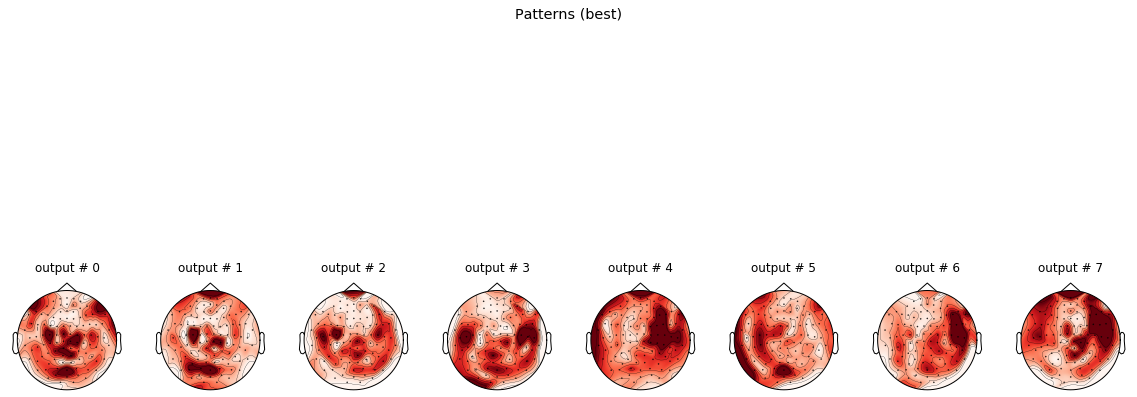

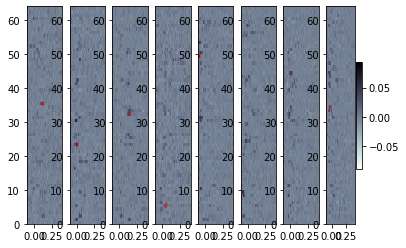

In [8]:
model.compute_patterns(data_path=meta['train_paths'], output='patterns')
f = model.plot_patterns(sensor_layout='Vectorview-grad', sorting='best', scale=False)

Maximum spearman r * weight: 0.03949404421794964
Maximum spearman r * weight: 0.09426751100881703
Maximum spearman r * weight: 0.040374833396868995
Maximum spearman r * weight: 0.05078028145723953
Maximum spearman r * weight: 0.058585083461050284
Maximum spearman r * weight: 0.05522210309875293
Maximum spearman r * weight: 0.044146646923843756
Maximum spearman r * weight: 0.04427839757827275


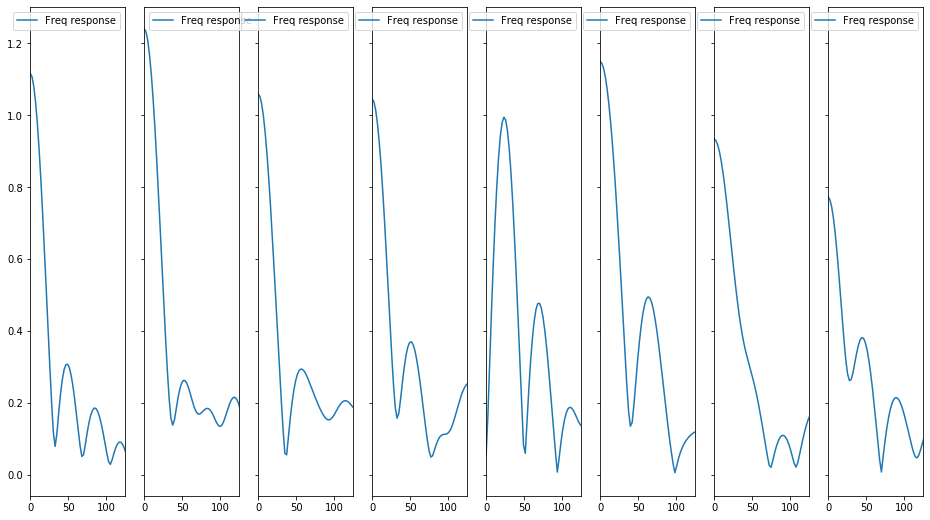

In [9]:
f3 = model.plot_spectra(sorting='best')

[None, 204, 302]
input x0 (?, 204, 302, 1)


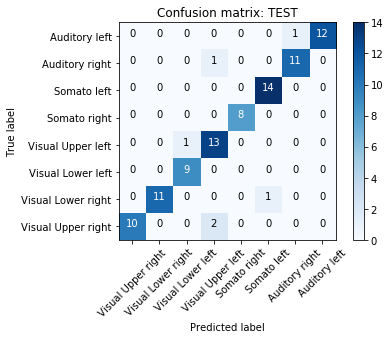

In [10]:
#Plotting the confusion matrix allows to identify analyze whether cetrain classes 
#are systematically harder to classify 
f2 = keras_models.plot_cm(model, dataset, steps=1, class_names=condition_names)

1/1 [==============================] - 0s 121ms/step - loss: 0.5675 - acc: 0.9362


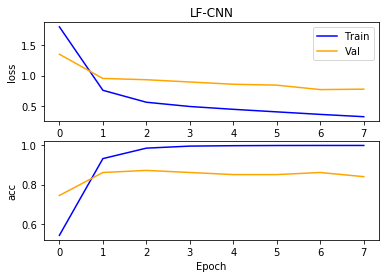

In [11]:
results = model.evaluate(dataset.test, steps=1, verbose=1)
plot_history_v2(history, title=model.name.upper(), nepochs=0, nend=None)

# 5. VARCNN

In [12]:
model = keras_models.VARCNN(graph_specs, dataset)
loss_f = tf.compat.v1.losses.softmax_cross_entropy

# % builtin
model.compile(loss=loss_f, optimizer=optim, metrics=['accuracy'])
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=1e-6, patience=1)

#train the model
history = model.fit(dataset.train, validation_data=dataset.val, epochs=3000, steps_per_epoch=200,
                    validation_steps=1, callbacks=[stop_early], verbose=1)

model.summary()


de-mix init : OK
conv init : OK
fc init : OK
[None, 204, 302]
input x0 (?, 204, 302, 1)
de-mix built : OK
dmx (?, 302, 1, 64)
conv build : OK
conv call: ok shape (?, 61, 1, 64)
fc ::: 3904 8
fc build : OK
Train for 200 steps, validate for 1 steps
Epoch 1/3000
[None, 204, 302]
input x0 (?, 204, 302, 1)
dmx (?, 302, 1, 64)
conv call: ok shape (?, 61, 1, 64)
[None, 204, 302]
input x0 (?, 204, 302, 1)
199/200 [============================>.] - ETA: 0s - loss: 2.0160 - acc: 0.8757[None, 204, 302]
input x0 (?, 204, 302, 1)
dmx (?, 302, 1, 64)
conv call: ok shape (?, 61, 1, 64)
200/200 [==============================] - 158s 792ms/step - loss: 2.0120 - acc: 0.8763 - val_loss: 1.9518 - val_acc: 0.7553
Epoch 2/3000
200/200 [==============================] - 123s 617ms/step - loss: 1.1889 - acc: 0.9932 - val_loss: 1.6792 - val_acc: 0.8191
Epoch 3/3000
200/200 [==============================] - 122s 609ms/step - loss: 1.1054 - acc: 0.9968 - val_loss: 1.6497 - val_acc: 0.7979
Epoch 4/3000
200/200 

1/1 [==============================] - 0s 190ms/step - loss: 0.4854 - acc: 0.9149


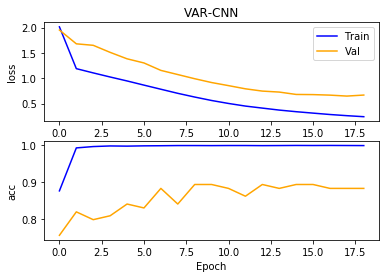

[None, 204, 302]
input x0 (?, 204, 302, 1)


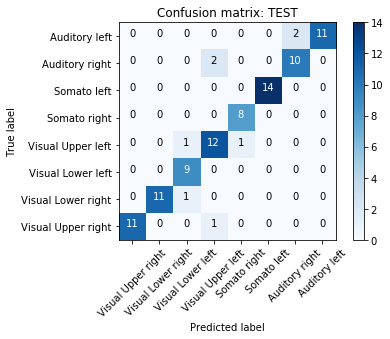

In [13]:
results = model.evaluate(dataset.test, steps=1, verbose=1)
plot_history_v2(history, title=model.name.upper(), nepochs=0, nend=None)
#Plotting the confusion matrix allows to identify analyze whether cetrain classes 
#are systematically harder to classify 
_ = keras_models.plot_cm(model, dataset, steps=1, class_names=condition_names)